# Anomaly Detection example

Anomaly detection in signals can be achieved using an autoencoder neural network. An autoencoder learns to reconstruct its input. If the input contains an unusual pattern (an anomaly) that the network hasn't learned well, the reconstruction error will be high for that part. 

In this example, we will train an autoencoder to model a known periodic signal so that it fails to reconstruct anomalies, thus flagging those anomalies via a large reconstruction error. We will use a Moku device to capture the signal data, then train a neural network model that can later be deployed on the Moku for real-time anomaly detection. 

## 1. Prepare the environment

Optional: if running on a fresh environment like Google Colab, install or upgrade the Moku API library (with Neural Network support) before proceeding.

In [1]:
# Uncomment and run this if Moku library is not installed
# !pip install -U "moku[neuralnetwork]"


Import the Python libraries

In [2]:
import csv
import os
import time
import numpy as np
import matplotlib.pyplot as plt

Import the Moku instrument classes and the neural network model utilities

In [3]:
from moku.instruments import MultiInstrument, Oscilloscope

try:
    from moku.nn import LinnModel, save_linn
except ImportError:
    print("Moku library is not installed. If running in an online notebook, install it with the pip command above.")
    raise


Define some helper functions for later use (formatting and data I/O):

In [4]:
def format_sampling_rate(rate):
    """Format a sampling rate in Hz to kHz or MHz if applicable."""
    if rate >= 1e6:
        return f"{rate/1e6:.2f} MHz"
    elif rate >= 1e3:
        return f"{rate/1e3:.2f} kHz"
    else:
        return f"{rate:.2f} Hz"

def save_data_to_csv(data_points, window_size, filename):
    """Save 1D data points into CSV file, splitting into fixed-size windows per row."""
    # Ensure all values are floats
    data_points = [float(x) for x in data_points]

    # Split data into consecutive windows of length window_size
    windows = []
    num_points = len(data_points)
    i = 0
    while i + window_size <= num_points:
        windows.append(data_points[i:i + window_size])
        i += window_size
    # Handle the last partial window (pad or adjust start to full length)
    if i < num_points:
        start = max(0, num_points - window_size)
        windows.append(data_points[start:num_points])

    # Determine next ID for data frames by counting existing rows in file
    file_exists = os.path.exists(filename)
    next_id = 0
    if file_exists:
        with open(filename, 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader, None)  # skip header
            next_id = sum(1 for _ in reader)

    # Append new data windows to the CSV
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(['id', 'data'])  # write header if new file
        for w in windows:
            writer.writerow([next_id, ';'.join(f"{x:.6f}" for x in w)])
            next_id += 1

    print(f"Total number of frames in the output file: {next_id}")

def load_data_from_csv(filename):
    """Load data windows from the CSV file back into a list of lists of float values."""
    data_windows = []
    with open(filename, 'r', newline='') as file:
        reader = csv.reader(file)
        header = next(reader, None)  # skip header if present
        for row in reader:
            if len(row) < 2:
                continue  # skip malformed rows
            # Each row's second column is a ';'-separated list of values
            values = [float(x) for x in row[1].split(';')]
            data_windows.append(values)
    return data_windows


ist the available Moku devices (using the Moku CLI as a quick check)

In [5]:
! mokucli list

Name                 Serial  HW     FW     IP                  
---------------------------------------------------------------
MokuGo-004186        4186    Go     606    fe80::7269:79ff:feb9:4168%16
MokuLab-002094       2094    Lab    609    10.50.0.51          
MokuPro-000323       323     Pro    606    fe80::7269:79ff:feb0:570%16
MokuGo-000051        51      Go     609    10.50.0.74          


The above command should output a list of connected Moku devices with their name, serial, IP, etc. Ensure your Moku device is listed and reachable.

## 2. Set up the Oscilloscope for data collection

First, set up the folder structure for output data and define the filename for saving captured data frames

In [6]:
# Define output folder and base filename
output_folder = "AD_dataset/"
output_filename = "data_training_27"

# Generate a unique filename with timestamp to avoid overwriting
timestamp = str(time.time()).split(".")[-1]
output_filename = f"{output_folder}{output_filename}_{timestamp}.csv"
print(f"Data will be saved in the file: {output_filename}" )


# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Folder created: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")


Data will be saved in the file: AD_dataset/data_training_27_257906.csv
Folder already exists: AD_dataset/


Now, deploy the Oscilloscope instrument on the Moku device. Connect to your Moku hardware by initializing a MultiInstrument with the device's IP address. In this example we use a Moku:Pro (platform_id 4). 

Note: Replace '10.1.119.245' with your Moku’s IP address (and adjust platform_id if using a different Moku model).

In [7]:
# Connect to the Moku device and deploy an Oscilloscope instrument
mim = MultiInstrument('10.1.119.245', force_connect=True, platform_id=4)
osc = mim.set_instrument(4, Oscilloscope)

connections = [dict(source="Input1", destination="Slot4InA")]
mim.set_connections(connections=connections)
mim.set_frontend(channel=1, impedance="50Ohm", coupling="DC", attenuation="-20dB")

{'attenuation': '-20dB', 'coupling': 'DC', 'impedance': '50Ohm'}

Configure the oscilloscope acquisition parameters. We define a window of interest and how many frames of data to capture

In [8]:
# Acquisition parameters
window_size = 100        # number of samples per frame (window length)
n_frames = 100           # number of frames to capture for dataset
t1 = 0.0                 # start time (seconds)
t2 = 0.1                 # end time (seconds) for each frame
duration = t2 - t1

# Set the oscilloscope timebase for each frame capture
osc.set_timebase(t1, t2)


{'t1': 0.0, 't2': 0.1}

Now collect the data frames from the oscilloscope. We will capture n_frames frames of channel data and save them to the CSV file defined above. The code below reads data from the Oscilloscope, uses our save_data_to_csv function to append each frame to the CSV, and prints progress as it goes.

In [9]:
for i in range(n_frames):
    data = osc.get_data()  # Get the data from the oscilloscope

    print(f'{i} - Saved {len(data["ch1"])} points from the oscilloscope')
    save_data_to_csv(data["ch1"], window_size, filename=output_filename)


0 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 11
1 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 22
2 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 33
3 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 44
4 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 55
5 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 66
6 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 77
7 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 88
8 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 99
9 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 110
10 - Saved 1024 points from the oscilloscope
Total number of frames in the output file: 121
11 - Sa

Now let's verify the sampling rate and examine one captured frame of data as an example

Sampling rate: 10.24 kHz


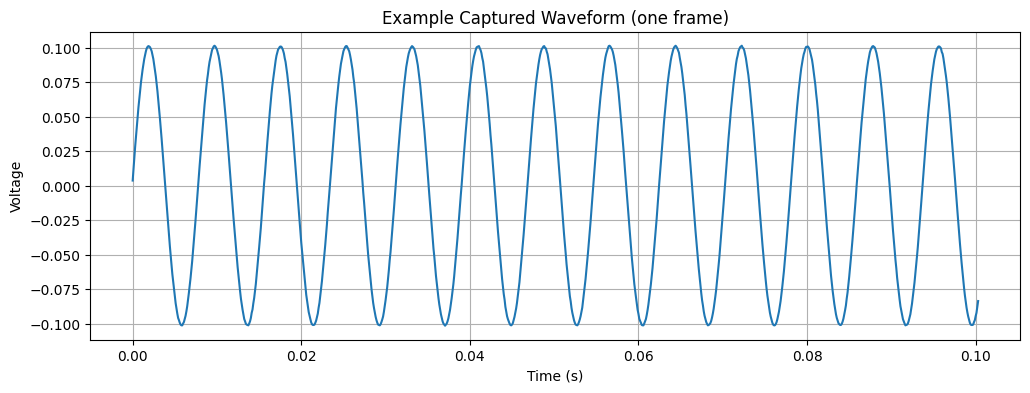

In [10]:
# Compute and display the sampling rate based on captured data
sampling_rate = len(data["ch1"]) / duration
print("Sampling rate:", format_sampling_rate(sampling_rate))

# Plot an example frame of the captured data
plt.figure(figsize=(12, 4))
plt.plot(data["time"], data["ch1"])
plt.title("Example Captured Waveform (one frame)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()


Print the first 100 datapoints of the frame. This 100-datapolint signal is an example of the training data that will be used for training the autoencoder.

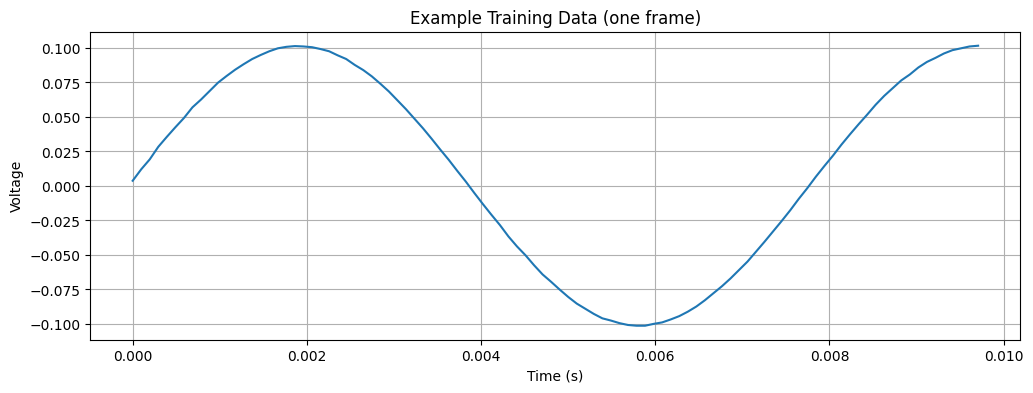

In [11]:
# Plot an example frame of the training data
plt.figure(figsize=(12, 4))
plt.plot(data["time"][:100], data["ch1"][:100])
plt.title("Example Training Data (one frame)")
plt.xlabel("Time (s)")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()


## 3. Compose the training dataset

Now that data has been collected, load it from the CSV and split it into training and testing sets for model development. We will use a simple 80/20 split

In [ ]:
# Read the saved frames from CSV
data = load_data_from_csv(output_filename)

# Split into training and testing datasets (80% train, 20% test)
split_index = int(len(data) * 0.8)
full_training_dataset = data[:split_index]
full_testing_dataset = data[split_index:]

print(f"N. of frames in the training dataset: {len(full_training_dataset)}")
print(f"N. of frames in the testing dataset: {len(full_testing_dataset)}")


N. of frames in the training dataset: 880
N. of frames in the testing dataset: 220


## 4. Define the model and train

Instantiate the Moku neural network model object

In [42]:
quant_mod = LinnModel()

Set up early stopping for training to avoid overfitting. We will monitor validation loss and stop if it doesn’t improve for 10 epochs, restoring the best weights

In [43]:
early_stopping_config = {
    'patience': 10,            # allow 10 epochs without improvement
    'restore_best_weights': True
}


Prepare the model definition. This is an autoencoder architecture: we use a small fully-connected neural network that compresses and then reconstructs the input signal. The model will output the same number of samples as the input frame (100). We disable automatic scaling of data (scale=False) because we want to work with raw values

In [44]:
frame_length = len(full_training_dataset[0])
print(f"frame length/input dimension: {frame_length}")

# Configure the model inputs/outputs (autoencoder: outputs = inputs)
quant_mod.set_training_data(training_inputs=full_training_dataset,
                             training_outputs=full_training_dataset,
                             scale=False)

# Define a simple autoencoder architecture: 
#  - encoder layers with 64, 32, 16 neurons (tanh activations)
#  - final decoder layer with 'frame_length' neurons (linear activation)
model_definition = [
    (64, 'tanh'),
    (32, 'tanh'),
    (16, 'tanh'),
    (frame_length, 'linear')
]

# Build the model
quant_mod.construct_model(model_definition)


frame length/input dimension: 100


Now train the model on the training dataset. We include a 10% validation split (which comes from the training set itself) for early stopping

In [45]:
history = quant_mod.fit_model(epochs=250, es_config=early_stopping_config, validation_split=0.1)


Value for monitor missing. Using default:val_loss.
Value for restore missing. Using default:False.


Epoch 1/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 2/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 3/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 5.5865e-04
Epoch 4/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8762e-04 - val_loss: 1.2261e-04
Epoch 5/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6439e-05 - val_loss: 7.2950e-05
Epoch 6/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5810e-05 - val_loss: 6.6823e-05
Epoch 7/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9137e-05 - val_loss: 6.4895e-05
Epoch 8/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5454e-05 - val_loss: 6.3766e-05
Epoch 9/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8440e-05 - val_loss: 6.2261e-05
Epoch 10/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1170e-05 - val_loss: 6.0653e-05
Epoch 11/250
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7936e-05 - val_loss: 5.9314

Plot the training and validation loss history to confirm convergence

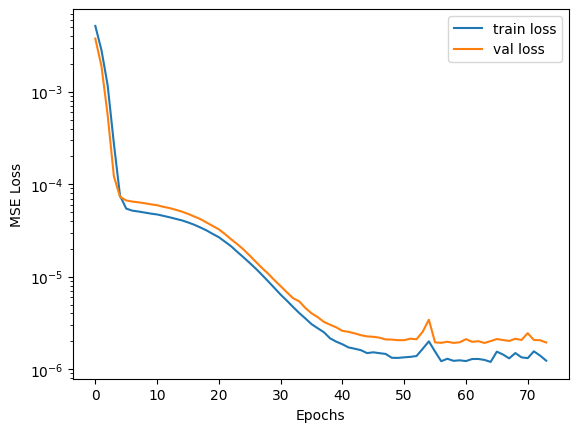

In [46]:
plt.semilogy(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()


In this case, the final loss values are extremely low, indicating the autoencoder learned to reconstruct normal signals very accurately.
Next save the model: after training, we save the quantized model to a file using save_linn. This will produce a .linn file that can be deployed to the Moku device’s FPGA for real-time inference.

In [47]:
model_filename = "AD_model_26.linn"
# Create a time-base array for mapping (same length as frame)
T = np.linspace(-1, 1, frame_length)
# Save the trained model to file
save_linn(quant_mod, input_channels=1, output_channels=1,
          file_name=model_filename, output_mapping=[T.size-1])


Skipping layer 0 with type <class 'keras.src.layers.core.input_layer.InputLayer'>
Skipping layer 2 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 4 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 6 with type <class 'moku.nn._linn.OutputClipLayer'>
Skipping layer 8 with type <class 'moku.nn._linn.OutputClipLayer'>
Network latency approx. 224 cycles


## 5. Testing the model - reconstruct the training dataset
Now that the model is trained, let’s verify how well it performs on data it saw during training. We feed the entire training dataset through the model to get reconstructed signals.

In [48]:
full_training_dataset_np = np.array(full_training_dataset)
reconstructions = quant_mod.predict(full_training_dataset_np, scale=False, unscale_output=False)


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


The reconstructions array contains the model output for each input frame. For a well-trained autoencoder, these reconstructed frames should closely match the originals. As a quick visual check, we can pick one training frame and compare it with its reconstruction

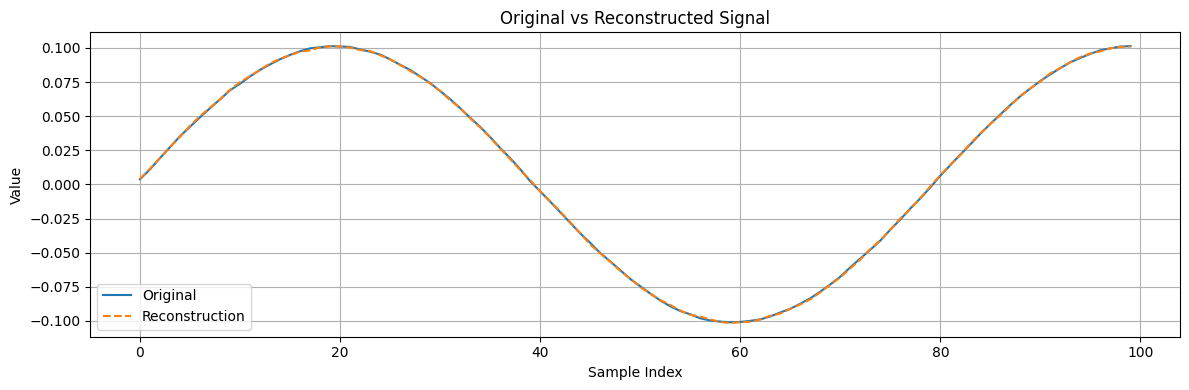

In [49]:
frame_id = 0  # for example, take the first training frame
plt.figure(figsize=(12, 4))
plt.plot(full_training_dataset[frame_id], label='Original')
plt.plot(reconstructions[frame_id], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Testing the model on the testing dataset (unseen data)
Now we evaluate the autoencoder on the testing dataset (the frames the model has never seen before). We expect the model to reconstruct normal frames well, but frames with anomalies (glitches) should yield a larger reconstruction error since the model was not trained on that behavior. Generate reconstructions for all test frames

In [50]:
full_testing_dataset_np = np.array(full_testing_dataset)
reconstructions_test = quant_mod.predict(full_testing_dataset_np)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


o illustrate the model’s performance, let's compare the output on a specific test frame that contains a known anomaly (glitch) versus a test frame that is normal. Suppose we know (or have identified) that frame index 147 in our dataset contains a glitch, and frame 146 is a normal frame for comparison

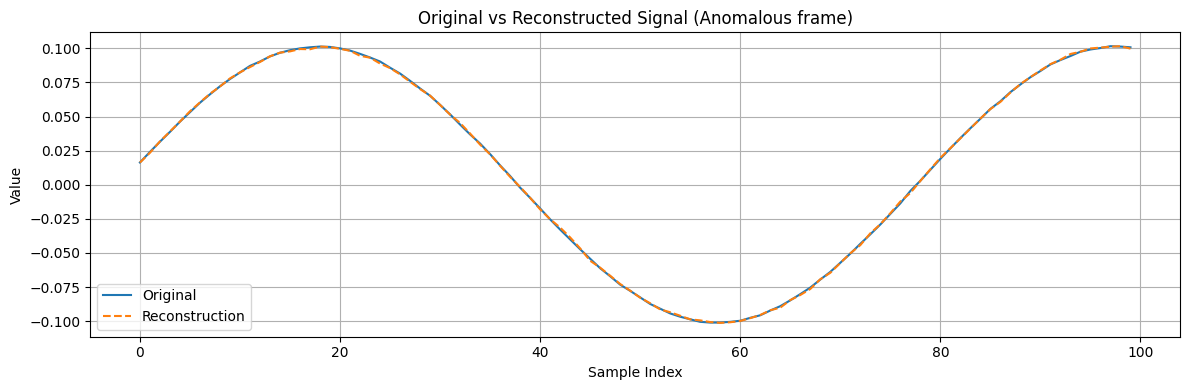

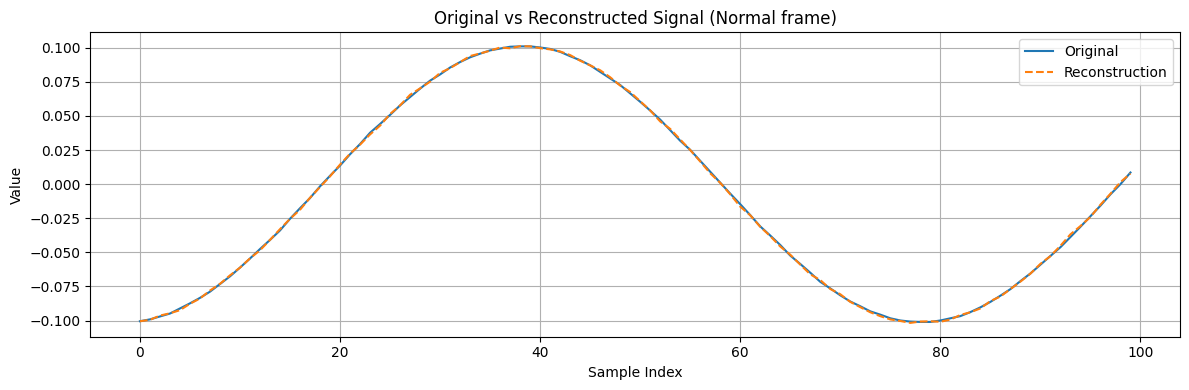

In [53]:
frame_id_anomaly_test = 147
frame_id_normal_test = 146 

# Plot original vs reconstructed for the anomalous frame
plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset[frame_id_anomaly_test], label='Original')
plt.plot(reconstructions_test[frame_id_anomaly_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal (Anomalous frame)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot original vs reconstructed for a normal frame
plt.figure(figsize=(12, 4))
plt.plot(full_testing_dataset[frame_id_normal_test], label='Original')
plt.plot(reconstructions_test[frame_id_normal_test], label='Reconstruction', linestyle='--')
plt.legend()
plt.title('Original vs Reconstructed Signal (Normal frame)')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


To detect the anomaly quantitatively, we need to examine the reconstruction error.

## 7. Extract the reconstruction error
Calculate the element-wise error between original and reconstructed signals for the test set.

In [23]:
original = np.array(full_testing_dataset)
reconstructed = np.array(reconstructions_test)

# --- Error calculations ---
# Absolute error for each sample
absolute_error = np.abs(original - reconstructed)
# Squared error for each sample
squared_error = (original - reconstructed) ** 2

# Summed error per frame (could be used as an anomaly score per frame)
absolute_error_per_frame = absolute_error.sum(axis=1)
squared_error_per_frame = squared_error.sum(axis=1)


Now, compare the error profiles of the previously chosen anomalous frame vs. the normal frame. We expect the frame with the glitch to show a spike in error at the glitch location, whereas the normal frame’s error should remain near zero across all sample indices. For example, we can plot the squared error for both frames on the same graph.

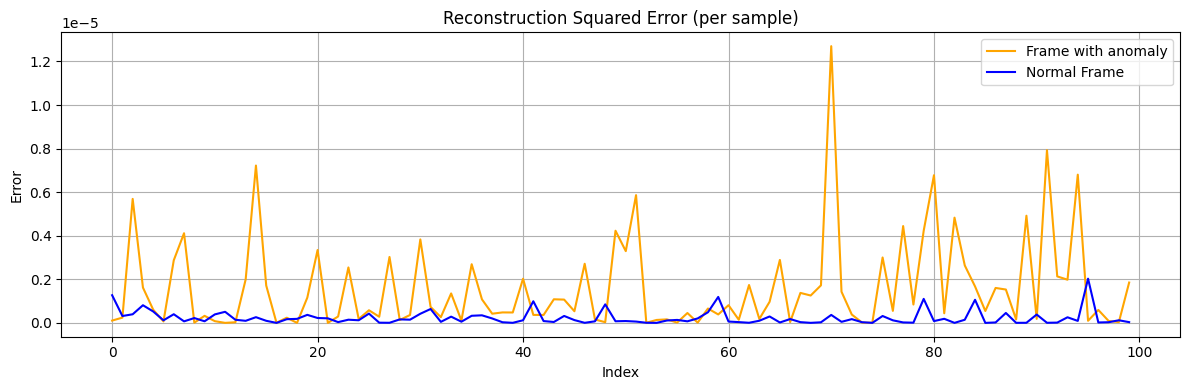

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(squared_error[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(squared_error[frame_id_normal_test], label='Normal Frame', color='blue')
plt.title('Reconstruction Squared Error (per sample)')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In the plot above, the anomalous frame has several spikes in error (orange curve) at certain sample indices, whereas the normal frame error (blue line) is essentially flat at zero. This indicates the autoencoder was unable to reconstruct those glitch points, as expected. We can further quantify this by checking which error values exceed a chosen threshold. For instance, using a threshold of 0.0002 (for absolute error) on our example.

In [25]:
threshold = 0.0002

# Find indices in the anomaly frame where absolute error > threshold
indices_anom = [i for i, v in enumerate(squared_error[frame_id_anomaly_test]) if v > threshold]
values_anom = [squared_error[frame_id_anomaly_test][i] for i in indices_anom]
print("Frame with anomaly")
print("Indices of values > threshold:", indices_anom)
print("Corresponding values:", values_anom)

print("—" * 70)

# Find indices in the normal frame where absolute error > threshold
indices_norm = [i for i, v in enumerate(squared_error[frame_id_normal_test]) if v > threshold]
values_norm = [squared_error[frame_id_normal_test][i] for i in indices_norm]
print("Normal frame")
print("Indices of values > threshold:", indices_norm)
print("Corresponding values:", values_norm)


Frame with anomaly
Indices of values > threshold: []
Corresponding values: []
——————————————————————————————————————————————————————————————————————
Normal frame
Indices of values > threshold: []
Corresponding values: []


As expected, the anomalous frame has a few samples where the reconstruction error exceeds the threshold, while the normal frame has none. These correspond to the glitch points in the signal. 

To further reduce false detections, we experimented with using higher-order error metrics. For example, defining a "focal MSE loss" (squared error raised to a power >1) can down-weight small differences and emphasize larger errors.

In [26]:
def focal_mse_loss(prediction, target, gamma=2.5):
    error = prediction - target
    squared_error = error ** 2
    return squared_error ** gamma

# Compute focal loss for each sample
focal_loss = focal_mse_loss(reconstructed, original)
focal_loss_per_frame = focal_loss.sum(axis=1)


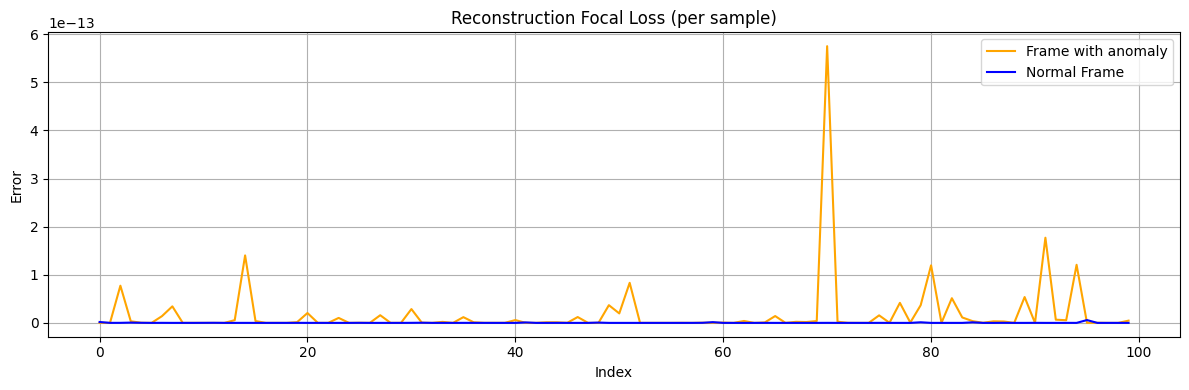

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(focal_loss[frame_id_anomaly_test], label='Frame with anomaly', color='orange')
plt.plot(focal_loss[frame_id_normal_test], label='Normal Frame', color='blue')
plt.title('Reconstruction Focal Loss (per sample)')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
threshold = 1e-9

# Find indices where value > threshold

# Frame with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_anomaly_test]) if v > threshold]

# Print results
print("Frame with anomaly")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_anomaly_test][i] for i in indices])


print("-------------------------------------------------------------------------------")


# Normal with Anomaly
indices = [i for i, v in enumerate(focal_loss[frame_id_normal_test]) if v > threshold]

# Print results
print("Normal frame")
print("Indices of values > threshold:", indices)
print("Corresponding values:", [focal_loss[frame_id_normal_test][i] for i in indices])

Frame with anomaly
Indices of values > threshold: []
Corresponding values: []
-------------------------------------------------------------------------------
Normal frame
Indices of values > threshold: []
Corresponding values: []


Overall, the autoencoder approach successfully learned the normal signal behavior and flagged the anomaly via reconstruction error. In summary:
- Normal frames: Reconstructed almost perfectly (near-zero error across all samples).
- Anomalous frame: Reconstruction deviates at the glitch points, yielding measurable error spikes.

This workflow demonstrates how an FPGA-deployable autoencoder (trained via Moku’s Python API) can perform real-time anomaly detection on signal data. The .linn model file saved can be loaded onto the Moku device to monitor incoming signals and detect anomalies based on the model’s reconstruction error in real time.

## Deploy on Moku

To test the model and deploy the anomaly detection feature, open your Moku on Multi-instrument mode. 

 Load the .linn file into the Neural Network instrument (slot 1, for example) on the device. Configure the instrument's input to the source signal (e.g., the output of a Waveform Generator or another signal source), and enable the output channel. In our anomaly detection setup, you would feed the original signal into the neural network instrument running this model. The instrument will output the reconstructed signal in real time.

 Using Multi-Instrument Mode, you can then, for instance, place an Oscilloscope in another slot to visualize both the original and reconstructed signals simultaneously. You should see that the reconstructed signal closely tracks the original except when anomalies occur (as we observed in the offline test). Because of processing latency, the reconstructed signal might be slightly delayed relative to the original. One strategy to compensate for this is to deploy a second neural network configured as an identity network (a network that simply outputs its input) in another slot to delay the original signal by the same amount. By aligning the timing in this way, you can directly compare the original and autoencoder output signals.

 Finally, to detect anomalies automatically, you can measure the difference between the original and reconstructed signals on the Moku. For example, you could use a custom Moku Cloud Compile (MCC) module that outputs the squared error. This error signal will spike when the original signal deviates from the learned normal pattern (i.e., when an anomaly occurs). By monitoring this error (for instance, using a threshold trigger on the Oscilloscope), the system can flag or log anomaly events in real time.

 ![MiM](tutorial_1.png)

![Reconstruction error in Channel C](tutorial_2.png)